In [1]:
# 전략: ARIMA 모델에 기술지표(이동평균선 등) feature를 결과를 더하고 결과를 ARIMA원본과 비교

In [2]:
#Colab에 주식관련 Lib 설치(Ta-Lib)

# (2020) https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

(Reading database ... 161006 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [3]:
# 1.data 다운로드
#구글 드라이브에서 다운로드
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
from io import BytesIO 
from googleapiclient.http import MediaIoBaseDownload

TEMP_PATH = '/tmp/'
def gcp_download(file_name, key):
    #3. 모델 다운로드
    #https://drive.google.com/open?id=1TlvbayGRCjAI6bOZrUYMmv6g6b95rnRM
    request = drive_service.files().get_media(fileId=key)

    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
      status, done = downloader.next_chunk()
      if status:
          print("Download %%%d%%." % int(status.progress() * 100))
      print("Download Complete!")
    downloaded.seek(0)

    with open(TEMP_PATH + file_name, 'wb') as f:
        f.write(downloaded.read())

In [4]:
#https://drive.google.com/file/d/1ckwh5Tp9PRSPu5dhfG8IzK8VjADQRplA
down_file_name = 'train_x_df.csv'
gcp_download(down_file_name, '1ckwh5Tp9PRSPu5dhfG8IzK8VjADQRplA') 

Download %6%.
Download Complete!
Download %12%.
Download Complete!
Download %18%.
Download Complete!
Download %24%.
Download Complete!
Download %30%.
Download Complete!
Download %36%.
Download Complete!
Download %42%.
Download Complete!
Download %48%.
Download Complete!
Download %54%.
Download Complete!
Download %60%.
Download Complete!
Download %66%.
Download Complete!
Download %73%.
Download Complete!
Download %79%.
Download Complete!
Download %85%.
Download Complete!
Download %91%.
Download Complete!
Download %97%.
Download Complete!
Download %100%.
Download Complete!


In [5]:
# https://drive.google.com/file/d/1PgnSkO8h2Bsn6B8PdsJi9D_TvD0NvbmU/view?usp=sharing
down_file_name = 'train_y_df.csv'
gcp_download(down_file_name, '1PgnSkO8h2Bsn6B8PdsJi9D_TvD0NvbmU') 

Download %70%.
Download Complete!
Download %100%.
Download Complete!


In [6]:
# https://drive.google.com/file/d/1SZ84Xtr-okI830fOAcKmA-5X09iqETVw
down_file_name = 'test_x_df.csv'
gcp_download(down_file_name, '1SZ84Xtr-okI830fOAcKmA-5X09iqETVw') 

Download %85%.
Download Complete!
Download %100%.
Download Complete!


In [7]:
# https://drive.google.com/file/d/1SZ84Xtr-okI830fOAcKmA-5X09iqETVw
down_file_name = 'sample_submission.csv'
gcp_download(down_file_name, '1SZ84Xtr-okI830fOAcKmA-5X09iqETVw') 

Download %85%.
Download Complete!
Download %100%.
Download Complete!


In [8]:
!mv /tmp/sample_submission.csv /content/
!mv /tmp/test_x_df.csv /content/
!mv /tmp/train_y_df.csv /content/
!mv /tmp/train_x_df.csv /content/

In [9]:
# 2. data 불러오기
import pandas as pd

data_path = '/content'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

print(len(train_x_df))
print(train_x_df.head())
print()
print(train_x_df.iloc[:, 2:].head())

10159560
   sample_id  time  coin_index  ...      trades    tb_base_av    tb_quote_av
0          0     0           7  ...  451.157288  7.326834e+05   37725.183594
1          0     1           7  ...   39.231071  0.000000e+00       0.000000
2          0     2           7  ...   58.846603  1.664967e+04     857.377808
3          0     3           7  ...  431.541779  2.189147e+06  112811.046875
4          0     4           7  ...  176.539810  0.000000e+00       0.000000

[5 rows x 12 columns]

   coin_index      open      high  ...      trades    tb_base_av    tb_quote_av
0           7  1.010004  1.010004  ...  451.157288  7.326834e+05   37725.183594
1           7  1.009808  1.009808  ...   39.231071  0.000000e+00       0.000000
2           7  1.009808  1.010200  ...   58.846603  1.664967e+04     857.377808
3           7  1.010200  1.011181  ...  431.541779  2.189147e+06  112811.046875
4           7  1.010985  1.010985  ...  176.539810  0.000000e+00       0.000000

[5 rows x 10 columns]


In [10]:
# coin별로 전체 샘플 건수 확인
train_x_df_group = train_x_df.groupby("coin_index").size()
print(train_x_df_group.head(12))
print()

# coin별로 샘플 사이즈 확인(23시간으로 나눈값)
train_x_df_group = train_x_df.groupby("coin_index").size()/1380 # 23시간 동안의 data임으로 coin단위로 sample건수 환산
print(train_x_df_group.head(12))

print()
train_y_df_group = train_y_df.groupby("coin_index").size()/1380 # 23시간 동안의 data임으로 coin단위로 sample건수 환산
print(train_y_df_group.head(12))

print()
test_x_df_group = test_x_df.groupby("coin_index").size()/1380 # 23시간 동안의 data임으로 coin단위로 sample건수 환산
print(test_x_df_group.head(12))

### 코인별로 다르게 예측하고, sum해야함!

coin_index
0    1251660
1     527160
2     139380
3     178020
4    1283400
5     752100
6    1469700
7    1306860
8    1625640
9    1625640
dtype: int64

coin_index
0     907.0
1     382.0
2     101.0
3     129.0
4     930.0
5     545.0
6    1065.0
7     947.0
8    1178.0
9    1178.0
dtype: float64

coin_index
0     78.869565
1     33.217391
2      8.782609
3     11.217391
4     80.869565
5     47.391304
6     92.608696
7     82.347826
8    102.434783
9    102.434783
dtype: float64

coin_index
0    53.0
1    53.0
2    53.0
3    53.0
4    53.0
5    53.0
6    53.0
7    53.0
8    53.0
9    52.0
dtype: float64


In [11]:
# 코인별 data-set 분리
train_x_df_map = {}
train_y_df_map = {}
test_x_df_map = {}

for idx in range(10):
  print("idx:", idx)
  df_x = train_x_df.loc[train_x_df.loc[:, "coin_index"]==idx]
  df_y = train_y_df.loc[train_y_df.loc[:, "coin_index"]==idx]
  df_z = test_x_df.loc[test_x_df.loc[:, "coin_index"]==idx]
  
  train_x_df_map[idx] = df_x
  train_y_df_map[idx] = df_y
  test_x_df_map[idx] = df_z


for idx in range(10):
  print("idx:", idx, " " , len(test_x_df_map[idx]))


idx: 0
idx: 1
idx: 2
idx: 3
idx: 4
idx: 5
idx: 6
idx: 7
idx: 8
idx: 9
idx: 0   73140
idx: 1   73140
idx: 2   73140
idx: 3   73140
idx: 4   73140
idx: 5   73140
idx: 6   73140
idx: 7   73140
idx: 8   73140
idx: 9   71760


In [12]:
print(train_x_df_map[0].head())
print()
print(train_x_df_map[0].tail())

      sample_id  time  coin_index  ...     trades  tb_base_av  tb_quote_av
1380          1     0           0  ...   1.573812    2.732137     9.601550
1381          1     1           0  ...   2.203336    0.000000     0.000000
1382          1     2           0  ...   6.295247   73.229462   257.038788
1383          1     3           0  ...   8.813346   13.796035    48.367622
1384          1     4           0  ...  15.423355   78.489143   274.863922

[5 rows x 12 columns]

          sample_id  time  coin_index  ...    trades  tb_base_av  tb_quote_av
10158175       7360  1375           0  ...  5.582582  234.137482   586.536072
10158176       7360  1376           0  ...  6.380094  102.308792   256.313110
10158177       7360  1377           0  ...  7.576362  104.330490   261.472382
10158178       7360  1378           0  ...  7.975117  384.504333   963.673950
10158179       7360  1379           0  ...  4.386314   26.916021    67.506454

[5 rows x 12 columns]


In [13]:
import pandas as pd 
import pandas_datareader as pdr
import talib 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import tensorflow as tf
import random as python_random

In [14]:
# 3. 기술지표 생성

def get_tech_indicatior(df):
    # data Feature
    df['next_price'] = df['close'].shift(-1) # 다음날 수익률 예측: 다음날 시가와 종가간의 수정종가를 하루 미뤄줌
    df['next_rtn'] = df['close'] / df['open'] -1
    df['log_return'] = np.log(1 + df['close'].pct_change())
    df['CCI'] = talib.CCI(df['high'], df['low'], df['close'], timeperiod=14)

    #1.RA(이동평균션) : Standard deviation rolling average
    # Moving Average
    df['MA5'] = talib.SMA(df['close'],timeperiod=5)
    df['MA10'] = talib.SMA(df['close'],timeperiod=10)
    df['RASD5'] = talib.SMA(talib.STDDEV(df['close'], timeperiod=5, nbdev=1),timeperiod=5)
    df['RASD10'] = talib.SMA(talib.STDDEV(df['close'], timeperiod=5, nbdev=1),timeperiod=10)

    #2.MACD : Moving Average Convergence/Divergence
    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd 

    # Momentum(모멘텀) Indicators
    #3.CCI : Commodity Channel Index
    df['CCI'] = talib.CCI(df['high'], df['low'], df['close'], timeperiod=14)
    # Volatility Indicators 

    #4.ATR(변동성) : Average True Range
    df['ATR'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)

    #5.BOLL(볼린저 밴드) : Bollinger Band
    upper, middle, lower = talib.BBANDS(df['close'],timeperiod=20,nbdevup=2,nbdevdn=2,matype=0)
    df['ub'] = upper
    df['middle'] = middle
    df['lb'] = lower

    #7.MTM1 
    df['MTM1'] = talib.MOM(df['close'], timeperiod=1)

    #7.MTM3
    df['MTM3'] = talib.MOM(df['close'], timeperiod=3)

    #8.ROC : Rate of change : ((price/prevPrice)-1)*100
    df['ROC'] = talib.ROC(df['close'], timeperiod=60)

    #9.WPR : william percent range (Williams' %R)
    df['WPR'] = talib.WILLR(df['high'], df['low'], df['close'], timeperiod=14)

    return df

for idx in train_x_df_map.keys():
    train_x_df_map[idx] = get_tech_indicatior(train_x_df_map[idx])
print(train_x_df_map[len(train_x_df_map.keys())-1].head())
print()

for idx in train_y_df_map.keys():
    train_y_df_map[idx] = get_tech_indicatior(train_y_df_map[idx])
print(train_y_df_map[len(train_y_df_map.keys())-1].head())
print()

for idx in test_x_df_map.keys():
    test_x_df_map[idx] = get_tech_indicatior(test_x_df_map[idx])
print(test_x_df_map[len(test_x_df_map.keys())-1].head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

      sample_id  time  coin_index      open  ...      MTM1      MTM3  ROC  WPR
5520          4     0           9  0.954524  ...       NaN       NaN  NaN  NaN
5521          4     1           9  0.953924  ... -0.000038       NaN  NaN  NaN
5522          4     2           9  0.953819  ... -0.000067       NaN  NaN  NaN
5523          4     3           9  0.953705  ...  0.001049  0.000944  NaN  NaN
5524          4     4           9  0.954756  ... -0.000763  0.000219  NaN  NaN

[5 rows x 29 columns]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

     sample_id  time  coin_index      open  ...      MTM1      MTM3  ROC  WPR
480          4     0           9  1.000305  ...       NaN       NaN  NaN  NaN
481          4     1           9  1.000305  ...  0.000000       NaN  NaN  NaN
482          4     2           9  1.000305  ...  0.000000       NaN  NaN  NaN
483          4     3           9  1.000305  ...  0.000000  0.000000  NaN  NaN
484          4     4           9  1.000304  ... -0.001653 -0.001653  NaN  NaN

[5 rows x 29 columns]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

       sample_id  time  coin_index      open  ...      MTM1      MTM3  ROC  WPR
41400         30     0           9  0.981082  ...       NaN       NaN  NaN  NaN
41401         30     1           9  0.979044  ...  0.000267       NaN  NaN  NaN
41402         30     2           9  0.979311  ...  0.000050       NaN  NaN  NaN
41403         30     3           9  0.979361  ... -0.001414 -0.001097  NaN  NaN
41404         30     4           9  0.977947  ...  0.002561  0.001197  NaN  NaN

[5 rows x 29 columns]


In [15]:
feature1_list = ['open','high','low','close','volume','log_return']
feature2_list = ['RASD5','RASD10','ub','lb','CCI','ATR','MACD','MA5','MA10','MTM1','MTM3','ROC','WPR']
#feature3_list = ['S&P500', 'SOX', 'VIX']
feature4_list = ['next_rtn']
all_features = feature1_list + feature2_list + feature4_list

In [16]:
# data 정규화
def min_max_normal(tmp_df):
    eng_list = []
    sample_df = tmp_df.copy()
    for x in all_features:
        if x in feature4_list :
            continue
        series = sample_df[x].copy()
        values = series.values
        values = values.reshape((len(values), 1))
        # train the normalization
        scaler = MinMaxScaler(feature_range=(0, 1)) #최소,최대 정규화
        scaler = scaler.fit(values)
#         print('columns : %s , Min: %f, Max: %f' % (x, scaler.data_min_, scaler.data_max_))
        # normalize the dataset and print
        normalized = scaler.transform(values)
        new_feature = '{}_normal'.format(x)
        eng_list.append(new_feature)
        sample_df[new_feature] = normalized
    return sample_df, eng_list

for idx in train_x_df_map.keys():
    train_x_df_map[idx], eng_list = min_max_normal(train_x_df_map[idx])
print(train_x_df_map[len(train_x_df_map.keys())-1].head())
print(eng_list)
print()

for idx in train_y_df_map.keys():
    train_y_df_map[idx], eng_list = min_max_normal(train_y_df_map[idx])
print(train_y_df_map[len(train_y_df_map.keys())-1].head())
print(eng_list)
print()

for idx in test_x_df_map.keys():
    test_x_df_map[idx], eng_list = min_max_normal(test_x_df_map[idx])
print(test_x_df_map[len(test_x_df_map.keys())-1].head())
print(eng_list)

      sample_id  time  coin_index  ...  MTM3_normal  ROC_normal  WPR_normal
5520          4     0           9  ...          NaN         NaN         NaN
5521          4     1           9  ...          NaN         NaN         NaN
5522          4     2           9  ...          NaN         NaN         NaN
5523          4     3           9  ...     0.311748         NaN         NaN
5524          4     4           9  ...     0.310748         NaN         NaN

[5 rows x 48 columns]
['open_normal', 'high_normal', 'low_normal', 'close_normal', 'volume_normal', 'log_return_normal', 'RASD5_normal', 'RASD10_normal', 'ub_normal', 'lb_normal', 'CCI_normal', 'ATR_normal', 'MACD_normal', 'MA5_normal', 'MA10_normal', 'MTM1_normal', 'MTM3_normal', 'ROC_normal', 'WPR_normal']

     sample_id  time  coin_index  ...  MTM3_normal  ROC_normal  WPR_normal
480          4     0           9  ...          NaN         NaN         NaN
481          4     1           9  ...          NaN         NaN         NaN
482    

In [17]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

train_x_df_map_arr = {}
train_y_df_map_arr = {}
test_x_df_map_arr = {}

# 코인별로 나눠서 3차원 data 만들기
for idx in train_x_df_map.keys():
    train_x_df_map_arr[idx] = df2d_to_array3d(train_x_df_map[idx])
for idx in train_y_df_map.keys():
    train_y_df_map_arr[idx] = df2d_to_array3d(train_y_df_map[idx])
for idx in test_x_df_map.keys():
    test_x_df_map_arr[idx] = df2d_to_array3d(test_x_df_map[idx])

# train_x_array = df2d_to_array3d(train_sample_df)
# train_y_array = df2d_to_array3d(val_sample_df)
# test_x_array = df2d_to_array3d(test_x_df)

print(f'''
train_x_array {train_x_df_map_arr[0].shape}
train_y_array {train_y_df_map_arr[0].shape}
test_x_array {test_x_df_map_arr[0].shape}
''')


train_x_array (907, 1380, 46)
train_y_array (907, 120, 46)
test_x_array (53, 1380, 46)



In [18]:
print(train_x_df_map_arr[9][idx, :, 1].shape)
print(train_x_df_map_arr[9][idx, :, 1])

(1380,)
[0.99300665 0.99331641 0.9933539  ... 1.00049579 1.00076318 1.        ]


In [19]:
print(train_x_df_map_arr[0][100,:, 1])
print(train_x_df_map[0].head())

[1.0223974  1.02519286 1.02502441 ... 0.99787813 0.99872017 1.        ]
      sample_id  time  coin_index  ...  MTM3_normal  ROC_normal  WPR_normal
1380          1     0           0  ...          NaN         NaN         NaN
1381          1     1           0  ...          NaN         NaN         NaN
1382          1     2           0  ...          NaN         NaN         NaN
1383          1     3           0  ...     0.246326         NaN         NaN
1384          1     4           0  ...     0.246400         NaN         NaN

[5 rows x 48 columns]


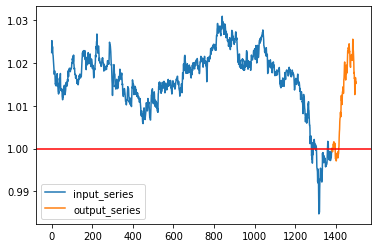

In [20]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 100
#plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plot_series(train_x_df_map_arr[0][idx,:, 1], train_y_df_map_arr[0][idx,:, 1])
plt.show()

In [21]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1380     1.106169
1381     1.104879
1382     1.104407
1383     1.103683
1384     1.102675
           ...   
86935    1.000297
86936    0.998105
86937    0.997808
86938    0.998774
86939    1.000000
Name: open, Length: 13800, dtype: float64



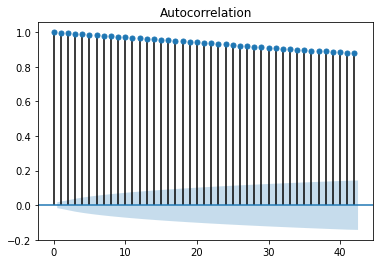

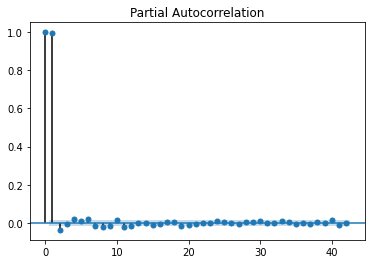

In [22]:
# Arima (p,q,d) 최적화
# 참고: https://byeongkijeong.github.io/ARIMA-with-Python/

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

idx = 100
#x_series = train_x_df_map_arr[0][idx,:,1] # 1: Open 가격
#x_series = train_x_df_map[0].loc[:, 'open'] # 천만row;;
x_series = train_x_df_map[0].loc[0:100000, 'open']
print(x_series)
print()

plot_acf(x_series)
plot_pacf(x_series)
plt.show()

## ACF는 변동이 거의 없고, 1에서 가장크다.
## PACF는 1의 Time lag에서 약 0.99를 보이고 이후에 급격히 감소한다. 
## 따라서 p=0, q=1이 적당하다고 추측할 수 있다.

In [23]:
print(train_x_df_map[0].head())
print(train_x_df_map[0].loc[:, 'open'])

      sample_id  time  coin_index  ...  MTM3_normal  ROC_normal  WPR_normal
1380          1     0           0  ...          NaN         NaN         NaN
1381          1     1           0  ...          NaN         NaN         NaN
1382          1     2           0  ...          NaN         NaN         NaN
1383          1     3           0  ...     0.246326         NaN         NaN
1384          1     4           0  ...     0.246400         NaN         NaN

[5 rows x 48 columns]
1380        1.106169
1381        1.104879
1382        1.104407
1383        1.103683
1384        1.102675
              ...   
10158175    0.998684
10158176    0.998923
10158177    0.999362
10158178    0.998923
10158179    1.000000
Name: open, Length: 1251660, dtype: float64


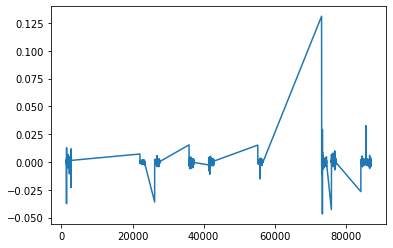

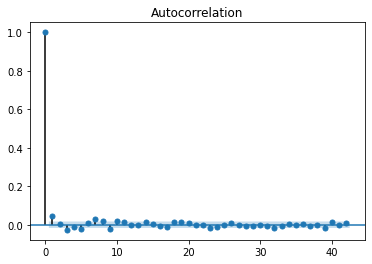

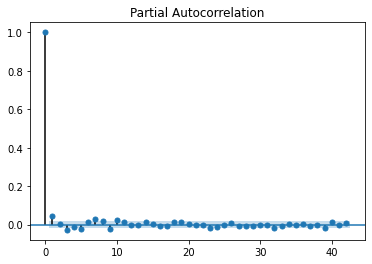

In [24]:
## 적절한 차분 차수의 계산을 위해 우선 1차 차분을 하고, ACF 및 PACF를 다시 계산한다.

diff_1= x_series.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1379
Model:                 ARIMA(0, 1, 1)   Log Likelihood                8657.441
Method:                       css-mle   S.D. of innovations              0.000
Date:                Sat, 27 Mar 2021   AIC                         -17308.883
Time:                        13:25:46   BIC                         -17293.195
Sample:                             1   HQIC                        -17303.014
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.086e-06   1.21e-05      0.255      0.799   -2.07e-05    2.68e-05
ma.L1.D.y     -0.0091      0.027     -0.332      0.740      -0.063       0.044
                                    Roots           

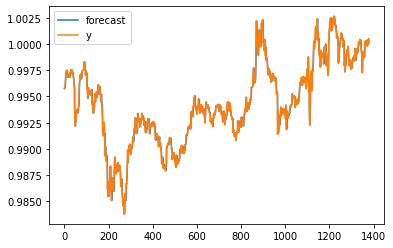

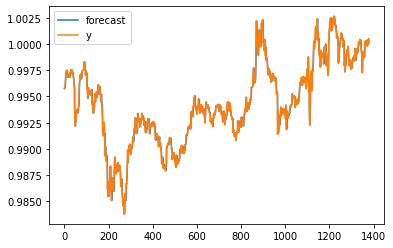

In [48]:
# ARIMA(0,1,1)을 이용하여 모형의 Parameter를 추정하고, 결과를 확인한다.
x_series = train_x_df_map_arr[0][idx,:,1] # 1: Open 가격
model = ARIMA(x_series, order=(0,1,1)) 
fit  = model.fit()
print(fit.summary())
print()

# P > z’ 값이 일반적으로 학습의 적정성을 위해 확인되는 t-test값이다. 
# 즉, p value 0.05수준에서 보면 MA(1)의 계수는 유효하고, 모형의 Constant는 유효하지 않다.
# 따라서, 위 코드에서 model.fit()의 파라미터중 trend=’c’가 아니라 ‘nc’로 설정해주어야 하는게 옳다.
model = ARIMA(x_series, order=(0,1,1)) 
fit  = model.fit(trend='nc',full_output=True, disp=1)
print(fit.summary())
print()

# constraint가 없는 모형으로 fitting하고 나니, MA(1)의 t-test값이 0.734로 더 좋아졌다.
fit.plot_predict()

<class 'statsmodels.tsa.arima_model.ARMAResultsWrapper'>


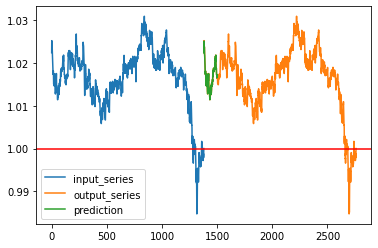

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1380
Model:                     ARMA(3, 1)   Log Likelihood                7712.884
Method:                       css-mle   S.D. of innovations              0.001
Date:                Sat, 27 Mar 2021   AIC                         -15413.768
Time:                        13:37:25   BIC                         -15382.389
Sample:                             0   HQIC                        -15402.029
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0153      0.004    288.397      0.000       1.008       1.022
ar.L1.y        0.1542      0.137      1.125      0.261      -0.114       0.423
ar.L2.y        0.7987      0.140      5.687      0.0

In [70]:
# train 샘플 훈련하기

idx = 100
# train data 중 sample_id 1121에 해당하는 x_series로 arima 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_df_map_arr[0][idx,:,1]
y_series = train_x_df_map_arr[0][idx,:,1]

# ARIMA의 (p,d,q) 값은 최적화 되지않은 값 입니다.
model = ARIMA(x_series, order=(3,0,1)) 
#model = ARIMA(x_series, order=(5,1,1)) 
fit  = model.fit()
#fit  = model.fit(trend='nc',full_output=True, disp=1)
print(type(fit))
#preds = fit.predict(1,120, typ='levels')
preds = fit.predict(1,120)

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), preds, label = 'prediction')
plt.legend()
plt.show()

print(fit.summary())

In [26]:
train_x_df_map[0].head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,next_price,next_rtn,log_return,CCI,MA5,MA10,RASD5,RASD10,MACD,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR,open_normal,high_normal,low_normal,close_normal,volume_normal,log_return_normal,RASD5_normal,RASD10_normal,ub_normal,lb_normal,CCI_normal,ATR_normal,MACD_normal,MA5_normal,MA10_normal,MTM1_normal,MTM3_normal,ROC_normal,WPR_normal
1380,1,0,0,1.106169,1.106169,1.104910,1.104910,13.367957,46.954517,1.573812,2.732137,9.601550,1.104312,-0.001138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.359874,0.339339,0.371424,0.356983,0.000035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1381,1,1,0,1.104879,1.104879,1.104312,1.104312,272.751038,957.261902,2.203336,0.000000,0.000000,1.103683,-0.000513,-0.000541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000598,NaN,NaN,NaN,0.358390,0.337824,0.370744,0.356293,0.000718,0.285413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.219293,NaN,NaN,NaN
1382,1,2,0,1.104407,1.105319,1.103683,1.103683,105.794769,371.359741,6.295247,73.229462,257.038788,1.102675,-0.000655,-0.000570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000629,NaN,NaN,NaN,0.357847,0.338341,0.370029,0.355567,0.000279,0.285371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.219254,NaN,NaN,NaN
1383,1,3,0,1.103683,1.104470,1.102518,1.102675,535.659424,1877.284180,8.813346,13.796035,48.367622,1.102140,-0.000913,-0.000913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001007,-0.002235,NaN,NaN,0.357014,0.337344,0.368706,0.354406,0.001410,0.284872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218789,0.246326,NaN,NaN
1384,1,4,0,1.102675,1.102675,1.101448,1.102140,1145.788452,4012.176758,15.423355,78.489143,274.863922,1.103368,-0.000485,-0.000485,NaN,1.103544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000535,-0.002172,NaN,NaN,0.355855,0.335238,0.367490,0.353789,0.003017,0.285495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.342479,NaN,0.219370,0.246400,NaN,NaN


In [27]:
# validation set 훈련하기

# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론

#todo. sample_id와 row_id의 재배열이 필요함? --> reset_index = true

valid_x_df_0 = train_x_df_map[0][train_x_df_map[0].sample_id < 1000]
valid_y_df_0 = train_y_df_map[0][train_y_df_map[0].sample_id < 1000]

valid_x_array = df2d_to_array3d(valid_x_df_0)
valid_y_array = df2d_to_array3d(valid_y_df_0)
#valid_pred_array = np.zeros([300, 120])
valid_pred_array = np.zeros([valid_x_array.shape[0],120])

In [28]:
print(valid_x_array.shape)
print(valid_x_array.shape[0])
print(valid_y_array.shape)
print(valid_pred_array.shape)
print(valid_y_df_0.tail())
print()
print(valid_x_df_0.tail())

(125, 1380, 46)
125
(125, 120, 46)
(125, 120)
        sample_id  time  coin_index  ...  MTM3_normal  ROC_normal  WPR_normal
119875        998   115           0  ...     0.633224    0.453845    0.049290
119876        998   116           0  ...     0.638867    0.456565    0.345070
119877        998   117           0  ...     0.636186    0.458213    0.380280
119878        998   118           0  ...     0.640560    0.457746    0.345338
119879        998   119           0  ...     0.630262    0.455331    0.161894

[5 rows x 48 columns]

         sample_id  time  coin_index  ...  MTM3_normal  ROC_normal  WPR_normal
1378615        998  1375           0  ...     0.250715    0.291444    1.000000
1378616        998  1376           0  ...     0.250154    0.290823    0.824168
1378617        998  1377           0  ...     0.250014    0.291133    0.819987
1378618        998  1378           0  ...     0.248892    0.291177    0.809991
1378619        998  1379           0  ...     0.249219    0.290910 

In [58]:
# 학습 및 추론하기

# ARIMA의 (p,d,q) 값이 (5,1,1)에서 수렴하지 않을 경우
# (4,1,1)로 변경하여 다시 학습 및 추론
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        try:
            x_series = valid_x_array[idx,:,1]

            #model = ARIMA(x_series, order=(5,1,1))
            model = ARIMA(x_series, order=(3,0,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            valid_pred_array[idx,:] = preds# - (preds[0]-x_series[-1])
        except:
            print("order 4 1 1")
            x_series = valid_x_array[idx,:,1]

            model = ARIMA(x_series, order=(4,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            valid_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        # ARIMA의 (p,d,q) 값이 (5,1,1), (4,1,1)에서 수렴하지 않을 경우
        # 모두 0으로 채움
        pass

  0%|          | 0/125 [00:00<?, ?it/s]

order 4 1 1


  1%|          | 1/125 [00:01<03:01,  1.46s/it]

order 4 1 1


  2%|▏         | 2/125 [00:02<02:51,  1.39s/it]

order 4 1 1


  2%|▏         | 3/125 [00:03<02:46,  1.36s/it]

order 4 1 1


  3%|▎         | 4/125 [00:05<02:48,  1.39s/it]

order 4 1 1


  4%|▍         | 5/125 [00:06<02:44,  1.37s/it]

order 4 1 1


  5%|▍         | 6/125 [00:07<02:34,  1.30s/it]

order 4 1 1


  6%|▌         | 7/125 [00:09<02:32,  1.29s/it]

order 4 1 1


  6%|▋         | 8/125 [00:10<02:39,  1.36s/it]

order 4 1 1


  7%|▋         | 9/125 [00:11<02:25,  1.26s/it]

order 4 1 1


  8%|▊         | 10/125 [00:12<01:57,  1.02s/it]

order 4 1 1


  9%|▉         | 11/125 [00:13<01:55,  1.02s/it]

order 4 1 1


 10%|▉         | 12/125 [00:14<02:00,  1.07s/it]

order 4 1 1


 10%|█         | 13/125 [00:15<01:56,  1.04s/it]

order 4 1 1


 11%|█         | 14/125 [00:16<01:55,  1.04s/it]

order 4 1 1


 12%|█▏        | 15/125 [00:17<01:58,  1.08s/it]

order 4 1 1


 13%|█▎        | 16/125 [00:18<01:57,  1.08s/it]

order 4 1 1


 14%|█▎        | 17/125 [00:20<02:05,  1.16s/it]

order 4 1 1


 14%|█▍        | 18/125 [00:20<01:50,  1.03s/it]

17  샘플은 수렴하지 않습니다.
order 4 1 1


 15%|█▌        | 19/125 [00:22<01:57,  1.10s/it]

order 4 1 1


 16%|█▌        | 20/125 [00:23<02:00,  1.15s/it]

order 4 1 1


 17%|█▋        | 21/125 [00:24<01:51,  1.07s/it]

20  샘플은 수렴하지 않습니다.
order 4 1 1


 18%|█▊        | 22/125 [00:25<01:57,  1.14s/it]

order 4 1 1


 18%|█▊        | 23/125 [00:26<01:44,  1.02s/it]

22  샘플은 수렴하지 않습니다.
order 4 1 1


 19%|█▉        | 24/125 [00:27<01:53,  1.12s/it]

order 4 1 1


 20%|██        | 25/125 [00:30<02:47,  1.68s/it]

order 4 1 1


 21%|██        | 26/125 [00:34<03:39,  2.22s/it]

order 4 1 1


 22%|██▏       | 27/125 [00:35<03:13,  1.97s/it]

order 4 1 1


 22%|██▏       | 28/125 [00:36<02:46,  1.71s/it]

order 4 1 1


 23%|██▎       | 29/125 [00:37<02:13,  1.39s/it]

order 4 1 1


 24%|██▍       | 30/125 [00:38<02:20,  1.48s/it]

order 4 1 1


 25%|██▍       | 31/125 [00:39<02:06,  1.35s/it]

order 4 1 1


 26%|██▌       | 32/125 [00:41<02:01,  1.30s/it]

order 4 1 1


 26%|██▋       | 33/125 [00:42<01:53,  1.23s/it]

order 4 1 1


 27%|██▋       | 34/125 [00:43<01:59,  1.31s/it]

order 4 1 1


 28%|██▊       | 35/125 [00:44<01:56,  1.29s/it]

order 4 1 1


 29%|██▉       | 36/125 [00:46<01:50,  1.25s/it]

order 4 1 1


 30%|██▉       | 37/125 [00:47<01:45,  1.20s/it]

order 4 1 1


 30%|███       | 38/125 [00:48<01:40,  1.16s/it]

order 4 1 1


 31%|███       | 39/125 [00:49<01:32,  1.08s/it]

order 4 1 1


 32%|███▏      | 40/125 [00:50<01:29,  1.05s/it]

order 4 1 1


 33%|███▎      | 41/125 [00:50<01:22,  1.02it/s]

order 4 1 1


 34%|███▎      | 42/125 [00:51<01:22,  1.00it/s]

order 4 1 1


 34%|███▍      | 43/125 [00:54<01:50,  1.34s/it]

order 4 1 1


 35%|███▌      | 44/125 [00:55<01:40,  1.24s/it]

order 4 1 1


 36%|███▌      | 45/125 [00:56<01:34,  1.18s/it]

order 4 1 1


 37%|███▋      | 46/125 [00:57<01:32,  1.16s/it]

order 4 1 1


 38%|███▊      | 47/125 [00:58<01:23,  1.07s/it]

order 4 1 1


 38%|███▊      | 48/125 [00:58<01:18,  1.02s/it]

order 4 1 1


 39%|███▉      | 49/125 [01:00<01:24,  1.11s/it]

order 4 1 1


 40%|████      | 50/125 [01:01<01:15,  1.01s/it]

order 4 1 1


 41%|████      | 51/125 [01:02<01:22,  1.11s/it]

order 4 1 1


 42%|████▏     | 52/125 [01:03<01:19,  1.10s/it]

order 4 1 1


 42%|████▏     | 53/125 [01:04<01:20,  1.12s/it]

order 4 1 1


 43%|████▎     | 54/125 [01:06<01:34,  1.33s/it]

order 4 1 1


 44%|████▍     | 55/125 [01:07<01:27,  1.25s/it]

order 4 1 1


 45%|████▍     | 56/125 [01:08<01:19,  1.16s/it]

order 4 1 1


 46%|████▌     | 57/125 [01:10<01:35,  1.41s/it]

order 4 1 1


 46%|████▋     | 58/125 [01:11<01:25,  1.28s/it]

order 4 1 1


 47%|████▋     | 59/125 [01:12<01:19,  1.20s/it]

order 4 1 1


 48%|████▊     | 60/125 [01:13<01:10,  1.09s/it]

order 4 1 1


 49%|████▉     | 61/125 [01:15<01:24,  1.32s/it]

order 4 1 1


 50%|████▉     | 62/125 [01:16<01:20,  1.28s/it]

order 4 1 1


 50%|█████     | 63/125 [01:17<01:25,  1.37s/it]

order 4 1 1


 51%|█████     | 64/125 [01:18<01:14,  1.22s/it]

order 4 1 1


 52%|█████▏    | 65/125 [01:20<01:24,  1.40s/it]

order 4 1 1


 53%|█████▎    | 66/125 [01:21<01:14,  1.27s/it]

order 4 1 1


 54%|█████▎    | 67/125 [01:24<01:38,  1.71s/it]

order 4 1 1


 54%|█████▍    | 68/125 [01:25<01:34,  1.66s/it]

order 4 1 1


 55%|█████▌    | 69/125 [01:26<01:23,  1.49s/it]

order 4 1 1


 56%|█████▌    | 70/125 [01:27<01:12,  1.32s/it]

order 4 1 1


 57%|█████▋    | 71/125 [01:29<01:15,  1.41s/it]

order 4 1 1


 58%|█████▊    | 72/125 [01:30<01:08,  1.30s/it]

order 4 1 1


 58%|█████▊    | 73/125 [01:32<01:16,  1.48s/it]

order 4 1 1


 59%|█████▉    | 74/125 [01:33<01:06,  1.31s/it]

order 4 1 1


 60%|██████    | 75/125 [01:34<01:05,  1.31s/it]

order 4 1 1


 61%|██████    | 76/125 [01:35<01:02,  1.28s/it]

order 4 1 1


 62%|██████▏   | 77/125 [01:37<01:02,  1.31s/it]

order 4 1 1


 62%|██████▏   | 78/125 [01:38<01:06,  1.41s/it]

order 4 1 1


 63%|██████▎   | 79/125 [01:40<01:09,  1.52s/it]

order 4 1 1


 64%|██████▍   | 80/125 [01:41<01:03,  1.41s/it]

order 4 1 1


 65%|██████▍   | 81/125 [01:43<01:01,  1.40s/it]

order 4 1 1


 66%|██████▌   | 82/125 [01:44<00:53,  1.25s/it]

order 4 1 1


 66%|██████▋   | 83/125 [01:45<00:54,  1.30s/it]

order 4 1 1


 67%|██████▋   | 84/125 [01:47<00:57,  1.41s/it]

order 4 1 1


 68%|██████▊   | 85/125 [01:49<01:01,  1.55s/it]

order 4 1 1


 69%|██████▉   | 86/125 [01:49<00:51,  1.31s/it]

order 4 1 1


 70%|██████▉   | 87/125 [01:51<00:56,  1.50s/it]

order 4 1 1


 70%|███████   | 88/125 [01:53<00:53,  1.44s/it]

order 4 1 1


 71%|███████   | 89/125 [01:53<00:45,  1.27s/it]

order 4 1 1


 72%|███████▏  | 90/125 [01:54<00:40,  1.16s/it]

order 4 1 1


 73%|███████▎  | 91/125 [01:56<00:43,  1.29s/it]

order 4 1 1


 74%|███████▎  | 92/125 [01:58<00:47,  1.44s/it]

order 4 1 1


 74%|███████▍  | 93/125 [01:59<00:45,  1.41s/it]

order 4 1 1


 75%|███████▌  | 94/125 [02:00<00:41,  1.34s/it]

order 4 1 1


 76%|███████▌  | 95/125 [02:02<00:43,  1.45s/it]

order 4 1 1


 77%|███████▋  | 96/125 [02:03<00:39,  1.36s/it]

order 4 1 1


 78%|███████▊  | 97/125 [02:04<00:36,  1.29s/it]

order 4 1 1


 78%|███████▊  | 98/125 [02:06<00:35,  1.30s/it]

order 4 1 1


 79%|███████▉  | 99/125 [02:07<00:35,  1.36s/it]

order 4 1 1


 80%|████████  | 100/125 [02:09<00:37,  1.51s/it]

order 4 1 1


 81%|████████  | 101/125 [02:12<00:48,  2.03s/it]

order 4 1 1


 82%|████████▏ | 102/125 [02:13<00:40,  1.74s/it]

order 4 1 1


 82%|████████▏ | 103/125 [02:14<00:33,  1.53s/it]

order 4 1 1


 83%|████████▎ | 104/125 [02:16<00:31,  1.48s/it]

order 4 1 1


 84%|████████▍ | 105/125 [02:17<00:29,  1.45s/it]

order 4 1 1


 85%|████████▍ | 106/125 [02:19<00:28,  1.51s/it]

order 4 1 1


 86%|████████▌ | 107/125 [02:20<00:24,  1.37s/it]

order 4 1 1


 86%|████████▋ | 108/125 [02:21<00:22,  1.31s/it]

order 4 1 1


 87%|████████▋ | 109/125 [02:22<00:19,  1.22s/it]

order 4 1 1


 88%|████████▊ | 110/125 [02:23<00:19,  1.29s/it]

order 4 1 1


 89%|████████▉ | 111/125 [02:24<00:16,  1.17s/it]

order 4 1 1


 90%|████████▉ | 112/125 [02:26<00:17,  1.32s/it]

order 4 1 1


 90%|█████████ | 113/125 [02:29<00:21,  1.82s/it]

order 4 1 1


 91%|█████████ | 114/125 [02:30<00:17,  1.57s/it]

order 4 1 1


 92%|█████████▏| 115/125 [02:31<00:13,  1.36s/it]

order 4 1 1


 93%|█████████▎| 116/125 [02:32<00:11,  1.24s/it]

order 4 1 1


 94%|█████████▎| 117/125 [02:33<00:09,  1.19s/it]

order 4 1 1


 94%|█████████▍| 118/125 [02:34<00:08,  1.22s/it]

order 4 1 1


 95%|█████████▌| 119/125 [02:35<00:06,  1.13s/it]

order 4 1 1


 96%|█████████▌| 120/125 [02:36<00:05,  1.04s/it]

order 4 1 1


 97%|█████████▋| 121/125 [02:37<00:03,  1.01it/s]

order 4 1 1


 98%|█████████▊| 122/125 [02:38<00:03,  1.17s/it]

order 4 1 1


 98%|█████████▊| 123/125 [02:45<00:05,  2.97s/it]

order 4 1 1


 99%|█████████▉| 124/125 [02:46<00:02,  2.38s/it]

order 4 1 1


100%|██████████| 125/125 [02:48<00:00,  1.35s/it]


In [59]:
valid_x_df_0.sample_id.unique()

array([  1,  16,  19,  26,  30,  40,  53,  55,  61,  62,  79,  89, 103,
       106, 110, 116, 119, 121, 124, 130, 135, 137, 138, 149, 151, 153,
       154, 161, 171, 175, 206, 209, 217, 233, 239, 244, 246, 266, 281,
       285, 291, 297, 300, 305, 322, 329, 332, 340, 343, 351, 355, 365,
       370, 380, 381, 395, 399, 407, 409, 419, 449, 451, 457, 460, 471,
       474, 486, 487, 494, 501, 506, 528, 534, 554, 593, 597, 599, 603,
       608, 614, 618, 620, 647, 648, 649, 663, 671, 689, 691, 692, 701,
       734, 742, 755, 759, 779, 787, 800, 804, 817, 841, 857, 871, 880,
       889, 894, 895, 899, 911, 914, 919, 921, 922, 937, 949, 960, 961,
       966, 970, 972, 973, 978, 984, 989, 998])

In [71]:
# valid_pred_array 로부터 buy_quantity, sell_time 구하기

#def array_to_submission(x_array, pred_array):
def array_to_submission(valid_x_df_0, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    #print('submission1:', submission.head())
    submission = submission.reset_index()
    #print('submission2:', submission.head())
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 115% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.15) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    submission['sample_id_orgin'] = valid_x_df_0.sample_id.unique()
    return submission

In [61]:
#valid_submission = array_to_submission(valid_x_array, valid_pred_array)
valid_submission = array_to_submission(valid_x_df_0, valid_pred_array)
print(valid_submission)

submission1:    buy_quantity  sell_time
0             0          0
1             0          0
2             0          0
3             0          0
4             0          0
submission2:    index  buy_quantity  sell_time
0      0             0          0
1      1             0          0
2      2             0          0
3      3             0          0
4      4             0          0
     sample_id  buy_quantity  sell_time  sample_id_orgin
0            0             0         24                1
1            1             0        119               16
2            2             0         13               19
3            3             0         21               26
4            4             0        118               30
..         ...           ...        ...              ...
120        120             0         83              973
121        121             0         12              978
122        122             0         53              984
123        123             0         5

In [62]:
# 전체 300가지 sample에 대해
# 9가지 case에서 115% 이상 상승한다고 추론함.
print(valid_submission.buy_quantity.value_counts())
print(valid_submission.shape)

0    120
1      5
Name: buy_quantity, dtype: int64
(125, 4)


In [84]:
# 투자 후 금액 계산하기

def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    #print('feature_size:', feature_size)

    time_size = len(df_2d.time.value_counts())
    #print('time_size:', time_size)

    sample_size = len(df_2d.sample_id.value_counts())
    #print('sample_size:', sample_size)

    sample_index = df_2d.sample_id.value_counts().index
    #print('df_2d.sample_id.value_counts():', df_2d.sample_id.value_counts())
    #print('sample_index:', sample_index)

    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    #print('array_2d.shape:', array_2d.shape)

    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer, money = 10000):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df) # index: sample_id index
    #print('y_array.shape:', y_array.shape)
    #print('index:', index)
    
    # index 기준으로 submission을 다시 선택
    #print('submission.columns[0]:', submission.columns[0])
    #submission = submission.set_index(submission.columns[0]) # sample_id
    #index를 다시 잡으면 아래 for 순회시 sample_id로 잡혀서 out_of_range발생.. 그냥 row_index를 사용하도록 둠.
    #submission = submission.set_index('sample_id_orgin') # sample_id  

    #print('submission.shape:', submission.shape)
    #submission = submission.iloc[index, :]    
    #print('submission:', submission.head())
    #print('submission:', submission.tail())
    
    # 초기 투자 비용은 10000 달러
    total_momey      = money # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    #print('submission.index:', submission.index)
    #print('len(y_array):', len(y_array))
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        #print('row_idx - start_index:', row_idx - start_index)
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [64]:
print(valid_y_df_0.head())
print()
print(valid_y_df_0.tail())
print()
# valid_y_df_0 = valid_y_df_0.reset_index()
# #valid_y_df_0 = valid_y_df_0.reset_index(ignore_index=True)
# print(valid_y_df_0.head())
# print(valid_y_df_0.tail())

     sample_id  time  coin_index  ...  MTM3_normal  ROC_normal  WPR_normal
120          1     0           0  ...          NaN         NaN         NaN
121          1     1           0  ...          NaN         NaN         NaN
122          1     2           0  ...          NaN         NaN         NaN
123          1     3           0  ...     0.632445         NaN         NaN
124          1     4           0  ...     0.633111         NaN         NaN

[5 rows x 48 columns]

        sample_id  time  coin_index  ...  MTM3_normal  ROC_normal  WPR_normal
119875        998   115           0  ...     0.633224    0.453845    0.049290
119876        998   116           0  ...     0.638867    0.456565    0.345070
119877        998   117           0  ...     0.636186    0.458213    0.380280
119878        998   118           0  ...     0.640560    0.457746    0.345338
119879        998   119           0  ...     0.630262    0.455331    0.161894

[5 rows x 48 columns]



(15000, 48)
(125, 4)
0
feature_size: 46
time_size: 120
sample_size: 125
sample_index: Int64Index([919, 554, 921, 937, 961,  26, 106, 130, 138, 154,
            ...
            501, 597, 701, 949, 973, 989,  30,  62, 110,  16],
           dtype='int64', length=125)
array_2d.shape: (125, 120)
y_array.shape: (125, 120)
index: [919, 554, 921, 937, 961, 26, 106, 130, 138, 154, 266, 322, 370, 474, 506, 618, 779, 914, 922, 970, 978, 19, 171, 291, 355, 395, 419, 451, 603, 691, 889, 857, 841, 817, 40, 528, 608, 648, 800, 880, 960, 984, 1, 89, 121, 137, 153, 161, 209, 217, 233, 281, 297, 305, 329, 409, 449, 457, 593, 649, 689, 755, 787, 911, 175, 534, 614, 734, 742, 894, 966, 998, 55, 79, 103, 119, 135, 151, 239, 899, 343, 351, 399, 407, 471, 487, 599, 647, 663, 671, 759, 871, 895, 494, 486, 246, 206, 116, 124, 244, 300, 332, 340, 380, 460, 620, 692, 804, 972, 53, 61, 149, 285, 365, 381, 501, 597, 701, 949, 973, 989, 30, 62, 110, 16]
submission.columns[0]: sample_id
submission.shape: (125, 4)
su

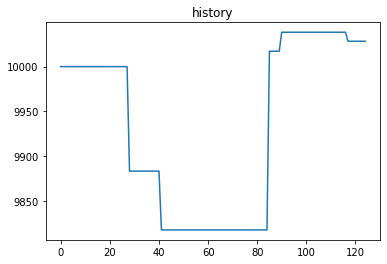

In [65]:
print(valid_y_df_0.shape)
print(valid_submission.shape)
print(valid_submission.index[0])
total_momey, total_momey_list = COIN(valid_y_df_0, valid_submission)

# 투자 후 금액
print(total_momey)

# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

In [72]:
# test 테이터도, coin별로 Set을 나누기
# => test_x_df_map[0~9]

# 개별 추론->결과 합치기(submission)
# => test_x_df_map_arr[0~9]

test_x_array_map = {}
for idx in range(10):
    test_x_array_map[idx] = test_x_df_map_arr[idx]
print(test_x_array_map[0].shape)

(53, 1380, 46)


In [73]:
# test 데이터 학습하고 추론하기 ??
# 훈련모델로 test 데이터 추론만 하면되는거 아닌가??
test_pred_array_map = {}
for key in test_x_array_map.keys():
    test_x_array = test_x_array_map[key]
    test_pred_array_map[key] = np.zeros([test_x_array.shape[0],120])

    for idx in tqdm(range(test_x_array.shape[0])):
        try:
            try:
                x_series = test_x_array[idx,:,1]

                model = ARIMA(x_series, order=(5,1,1))
                fit  = model.fit()
                preds = fit.predict(1,120, typ='levels')
                test_pred_array_map[key][idx,:] = preds
            except:
                x_series = test_x_array[idx,:,1]
                model = ARIMA(x_series, order=(4,1,1))
                fit  = model.fit()
                preds = fit.predict(1,120, typ='levels')
                test_pred_array_map[key][idx,:] = preds
        except:
            print(idx, " 샘플은 수렴하지 않습니다.")
            pass

# test set coin별 수익률 확인 + 결과 합치기?

100%|██████████| 52/52 [00:57<00:00,  1.10s/it]


(53, 1380, 46)
(1380,)
(53, 120)
(120,)


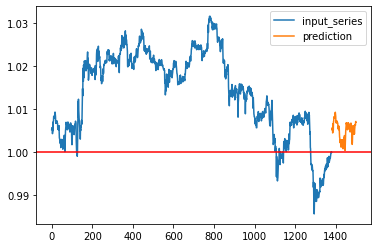

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1379
Model:                 ARIMA(5, 1, 1)   Log Likelihood                6571.036
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 27 Mar 2021   AIC                         -13126.071
Time:                        14:10:36   BIC                         -13084.238
Sample:                             1   HQIC                        -13110.422
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   6.06e-05      2.028      0.043    4.11e-06       0.000
ar.L1.D.y     -0.1916      0.381     -0.502      0.615      -0.939       0.556
ar.L2.D.y     -0.0431      0.056     -0.769      0.4

In [80]:
def plot_series2(x_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    # plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
    #          y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

x_series = test_x_array_map[0]
print(x_series.shape)
print(x_series[idx, :, 1].shape)
preds = test_pred_array_map[0]
print(preds.shape)
print(preds[idx, :].shape)

idx = 0
plot_series2(x_series[idx, :, 1])
plt.plot(np.arange(1380, 1380+120), preds[idx, :], label = 'prediction')
plt.legend()
plt.show()

print(fit.summary())

In [120]:
submission_map = {}
for idx in test_x_df_map.keys():
    test_x_df = test_x_df_map[idx]
    #print(test_x_df.shape)

    # 추론한 test_pred_array를 바탕으로 submission df 생성하기
    submission_map[idx] = array_to_submission(test_x_df, test_pred_array_map[idx])
    
for idx in submission_map.keys():
    if idx == 0:
        submission = submission_map[0]
        continue
    submission = pd.concat([submission, submission_map[idx]], ignore_index=True)

#submission.to_csv("submission.csv", index = False)
submission.head()

,sample_id,buy_quantity,sell_time,sample_id_orgin
0,0,0,17,1
1,1,0,74,13
2,2,0,0,16
3,3,0,15,29
4,4,0,112,31


In [121]:
print(len(submission))
print(submission.head())

# 컬럼제거
submission = submission.drop("sample_id", axis=1) # df = df.drop(columns="A")
print(submission.head())

# 컬럼(index) 이름 변경
submission.rename(columns = {'sample_id_orgin' : 'sample_id'}, inplace = True)
#submission.columns = ['sample_id', 'buy_quantity', 'sell_time']
print(submission.head())

#index 변경
submission = submission.set_index("sample_id")
print(submission.head())

# 정렬
submission = submission.sort_values(by=["sample_id"], ascending=True)
print(submission.head(10))

submission.to_csv("submission.csv", index = True)

529
   sample_id  buy_quantity  sell_time  sample_id_orgin
0          0             0         17                1
1          1             0         74               13
2          2             0          0               16
3          3             0         15               29
4          4             0        112               31
   buy_quantity  sell_time  sample_id_orgin
0             0         17                1
1             0         74               13
2             0          0               16
3             0         15               29
4             0        112               31
   buy_quantity  sell_time  sample_id
0             0         17          1
1             0         74         13
2             0          0         16
3             0         15         29
4             0        112         31
           buy_quantity  sell_time
sample_id                         
1                     0         17
13                    0         74
16                    0          0

In [114]:
# 전체 300가지 sample에 대해
# 9가지 case에서 115% 이상 상승한다고 추론함.
print(submission.buy_quantity.value_counts())
print(submission.shape)

0    505
1     24
Name: buy_quantity, dtype: int64
(529, 2)


1009.7421682107649
1006.3181052913283
1011.6921491682841
1031.4396417705539
1033.560917828394
1513.9069470545141
1006.8950006146904
1043.1674991382877
1013.5708148457784
1004.5865519310078
sum_total_momey: 10674.879795853603


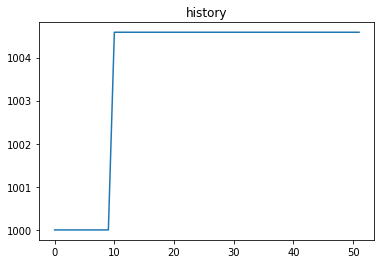

In [115]:
sum_total_momey = 0
for idx in test_x_df_map.keys():
    test_x_df = test_x_df_map[idx]
    submission = submission_map[idx]

    total_momey, total_momey_list = COIN(test_x_df, submission, money=1000)
    sum_total_momey += total_momey
    # 투자 후 금액
    print(total_momey)

print('sum_total_momey:', sum_total_momey)

# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()